Change from 2.1

- RF instead of GLM

For reference, check https://github.com/drivendata/benchmarks/blob/master/dengue-benchmark-statsmodels.ipynb

In [2]:
from matplotlib import pyplot as plt
import pandas as pd

In [3]:
from src.features.build_features import load_raw

df_all = load_raw()
df_all.keys()

dict_keys(['features_train', 'features_test', 'labels_train', 'submission'])

In [4]:
df_all['features_train'].head(n=2)

year  weekofyear   ndvi_ne   ndvi_nw   ndvi_se  \
city week_start_date                                                   
iq   2000-07-01       2000          26  0.192886  0.132257  0.340886   
     2000-07-08       2000          27  0.216833  0.276100  0.289457   

                       ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  \
city week_start_date                                                          
iq   2000-07-01       0.247200                 25.41             296.740000   
     2000-07-08       0.241657                 60.61             296.634286   

                      reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
city week_start_date                                                       
iq   2000-07-01                  298.450000                   295.184286   
     2000-07-08                  298.428571                   295.358571   

                            ...          reanalysis_precip_amt_kg_per_m2  \
city week_start_date        ...                                            
iq   2000-07-01             ...                                    43.19   
     2000-07-08             ...                                    46.00   

                      reanalysis_relative_humidity_percent  \
city week_start_date                                         
iq   2000-07-01                                  92.418571   
     2000-07-08                                  93.581429   

                      reanalysis_sat_precip_amt_mm  \
city week_start_date                                 
iq   2000-07-01                              25.41   
     2000-07-08                              60.61   

                      reanalysis_specific_humidity_g_per_kg  \
city week_start_date                                          
iq   2000-07-01                                   16.651429   
     2000-07-08                                   16.862857   

                      reanalysis_tdtr_k  station_avg_temp_c  \
city week_start_date                                          
iq   2000-07-01                8.928571                26.4   
     2000-07-08               10.314286                26.9   

                      station_diur_temp_rng_c  station_max_temp_c  \
city week_start_date                                                
iq   2000-07-01                     10.775000                32.5   
     2000-07-08                     11.566667                34.0   

                      station_min_temp_c  station_precip_mm  
city week_start_date                                         
iq   2000-07-01                     20.7                3.0  
     2000-07-08                     20.8               55.6  

[2 rows x 22 columns]

In [5]:
df_all['labels_train'].head(n=2)

year  weekofyear  total_cases
city week_start_date                               
sj   1990-04-30       1990          18            4
     1990-05-07       1990          19            5

## fillna

In [6]:
for k in ['features_train', 'features_test']:
    df_all[k] = df_all[k].groupby('city').apply(lambda group: group.fillna(method='ffill'))
    assert ~(pd.isnull(df_all[k]).any().any())

## train/test split

In [22]:
# features selected from
# https://github.com/drivendata/benchmarks/blob/master/dengue-benchmark-statsmodels.ipynb
#selected_features = ['reanalysis_specific_humidity_g_per_kg', 
#                 'reanalysis_dew_point_temp_k', 
#                 'station_avg_temp_c', 
#                 'station_min_temp_c']
selected_features = df_all['features_train'].columns
assert len(set(selected_features) - set(df_all['features_train'].columns))==0

In [8]:
df_all['features_train'].shape, df_all['labels_train'].shape

((1456, 22), (1456, 3))

In [23]:
# note avoiding class bias
x_train = (df_all['features_train']
          .groupby(level='city', as_index=False)
          .apply(lambda group: group.head(n=group.shape[0]*3//4))
          .reset_index(level=0, drop=True)
          [selected_features]
          )
x_test = (df_all['features_train']
          .groupby(level='city', as_index=False)
          .apply(lambda group: group.tail(n=group.shape[0]*1//4))
          .reset_index(level=0, drop=True)
          [selected_features]
         )
y_train = (df_all['labels_train']
          .groupby('city', as_index=False)
          .apply(lambda group: group.head(n=group.shape[0]*3//4))
          .reset_index(level=0, drop=True)
          ['total_cases']
         )
y_test = (df_all['labels_train']
          .groupby('city', as_index=False)
          .apply(lambda group: group.tail(n=group.shape[0]*1//4))
          .reset_index(level=0, drop=True)
          ['total_cases']
         )

x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1092, 22), (364, 22), (1092,), (364,))

In [24]:
x_train.groupby('city').head()

year  weekofyear   ndvi_ne   ndvi_nw   ndvi_se  \
city week_start_date                                                   
iq   2000-07-01       2000          26  0.192886  0.132257  0.340886   
     2000-07-08       2000          27  0.216833  0.276100  0.289457   
     2000-07-15       2000          28  0.176757  0.173129  0.204114   
     2000-07-22       2000          29  0.227729  0.145429  0.254200   
     2000-07-29       2000          30  0.328643  0.322129  0.254371   
sj   1990-04-30       1990          18  0.122600  0.103725  0.198483   
     1990-05-07       1990          19  0.169900  0.142175  0.162357   
     1990-05-14       1990          20  0.032250  0.172967  0.157200   
     1990-05-21       1990          21  0.128633  0.245067  0.227557   
     1990-05-28       1990          22  0.196200  0.262200  0.251200   

                       ndvi_sw  precipitation_amt_mm  reanalysis_air_temp_k  \
city week_start_date                                                          
iq   2000-07-01       0.247200                 25.41             296.740000   
     2000-07-08       0.241657                 60.61             296.634286   
     2000-07-15       0.128014                 55.52             296.415714   
     2000-07-22       0.200314                  5.60             295.357143   
     2000-07-29       0.361043                 62.76             296.432857   
sj   1990-04-30       0.177617                 12.42             297.572857   
     1990-05-07       0.155486                 22.82             298.211429   
     1990-05-14       0.170843                 34.54             298.781429   
     1990-05-21       0.235886                 15.36             298.987143   
     1990-05-28       0.247340                  7.52             299.518571   

                      reanalysis_avg_temp_k  reanalysis_dew_point_temp_k  \
city week_start_date                                                       
iq   2000-07-01                  298.450000                   295.184286   
     2000-07-08                  298.428571                   295.358571   
     2000-07-15                  297.392857                   295.622857   
     2000-07-22                  296.228571                   292.797143   
     2000-07-29                  297.635714                   293.957143   
sj   1990-04-30                  297.742857                   292.414286   
     1990-05-07                  298.442857                   293.951429   
     1990-05-14                  298.878571                   295.434286   
     1990-05-21                  299.228571                   295.310000   
     1990-05-28                  299.664286                   295.821429   

                            ...          reanalysis_precip_amt_kg_per_m2  \
city week_start_date        ...                                            
iq   2000-07-01             ...                                    43.19   
     2000-07-08             ...                                    46.00   
     2000-07-15             ...                                    64.77   
     2000-07-22             ...                                    23.96   
     2000-07-29             ...                                    31.80   
sj   1990-04-30             ...                                    32.00   
     1990-05-07             ...                                    17.94   
     1990-05-14             ...                                    26.10   
     1990-05-21             ...                                    13.90   
     1990-05-28             ...                                    12.20   

                      reanalysis_relative_humidity_percent  \
city week_start_date                                         
iq   2000-07-01                                  92.418571   
     2000-07-08                                  93.581429   
     2000-07-15                                  95.848571   
     2000-07-22                                  87.234286   
     2000-

In [25]:
set(y_train.reset_index()['city'])

{'iq', 'sj'}

## fit RF

In [26]:
# http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor

In [39]:
mod1_sj = RandomForestRegressor(n_estimators=100, min_samples_split=5, min_samples_leaf=3)
mod1_sj.fit(X = x_train.loc['sj'], y = y_train.loc['sj'])
mod1_iq = RandomForestRegressor(n_estimators=100, min_samples_split=5, min_samples_leaf=3)
mod1_iq.fit(X = x_train.loc['iq'], y = y_train.loc['iq'])

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=5,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

## predict on test set

In [40]:
# cast to int since we know the label is integer
predictions = (y_test.copy()*0).astype('int')

predictions.loc['sj'] = mod1_sj.predict(x_test.loc['sj']).astype(int)
predictions.loc['iq'] = mod1_iq.predict(x_test.loc['iq']).astype(int)

predictions.loc['sj'].head()

week_start_date
2003-10-29    79
2003-11-05    30
2003-11-12    39
2003-11-19    31
2003-11-26    26
Name: total_cases, dtype: int64

In [41]:
'sj', mod1_sj.score(x_test.loc['sj'], y_test.loc['sj']), 'iq', mod1_iq.score(x_test.loc['iq'], y_test.loc['iq'])

('sj', 0.10434001299725049, 'iq', -0.06521307071651461)

## plot

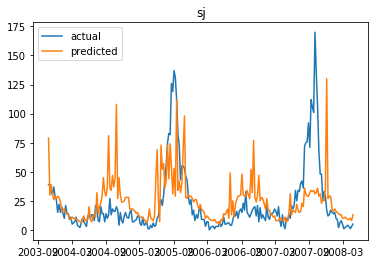

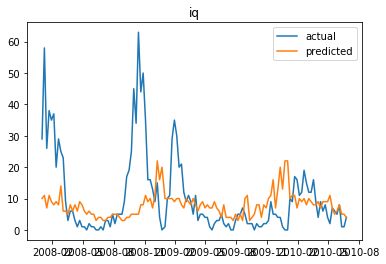

In [42]:
for city in ['sj', 'iq']:
    plt.plot(y_test.loc[city], label='actual')
    plt.plot(predictions.loc[city], label='predicted')
    plt.title(city)
    plt.legend()
    plt.show()

## set in submission

In [43]:
df_all['submission'].loc['sj'].head()

,year,weekofyear,total_cases
week_start_date,,,
2008-04-29,2008,18,0
2008-05-06,2008,19,0
2008-05-13,2008,20,0
2008-05-20,2008,21,0
2008-05-27,2008,22,0


In [45]:
# cast to int since we know the label is integer
predictions = (df_all['submission']['total_cases'].copy()*0).astype('int')

predictions.loc['sj'] = mod1_sj.predict(df_all['features_test'].loc['sj', selected_features]).astype(int)
predictions.loc['iq'] = mod1_iq.predict(df_all['features_test'].loc['iq', selected_features]).astype(int)

predictions.loc['sj'].head()

week_start_date
2008-04-29     6
2008-05-06    10
2008-05-13     8
2008-05-20    12
2008-05-27    12
Name: total_cases, dtype: int64

In [46]:
predictions.groupby(level='city').head()

city  week_start_date
sj    2008-04-29          6
      2008-05-06         10
      2008-05-13          8
      2008-05-20         12
      2008-05-27         12
iq    2010-07-02          6
      2010-07-09          3
      2010-07-16          7
      2010-07-23          4
      2010-07-30          4
Name: total_cases, dtype: int64

In [47]:
submit = df_all['submission'].copy()
submit['total_cases'] = predictions

In [48]:
submit.shape

(416, 3)

In [49]:
submit.head()

year  weekofyear  total_cases
city week_start_date                               
sj   2008-04-29       2008          18            6
     2008-05-06       2008          19           10
     2008-05-13       2008          20            8
     2008-05-20       2008          21           12
     2008-05-27       2008          22           12

## plot

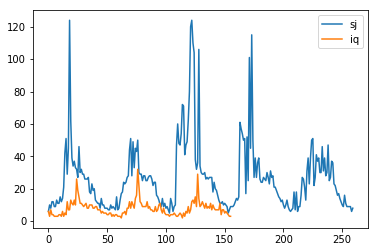

In [50]:
for city in ['sj','iq']:
    plt.plot(submit.loc[city, 'total_cases'].values, label=city)
    
plt.legend()
plt.show()

## Compare to result of notebook 1-...ipynb

In [51]:
df_prev = (pd.read_csv('data/interim/1-submission_20180530_092740-score_29.csv')
             .merge(submit.reset_index(), how='left', on=['city', 'year', 'weekofyear'], suffixes=['_prev', '_curr'])
          ).set_index(['city', 'week_start_date'])
df_prev.head()

year  weekofyear  total_cases_prev  total_cases_curr
city week_start_date                                                      
sj   2008-04-29       2008          18                10                 6
     2008-05-06       2008          19                 8                10
     2008-05-13       2008          20                13                 8
     2008-05-20       2008          21                10                12
     2008-05-27       2008          22                21                12

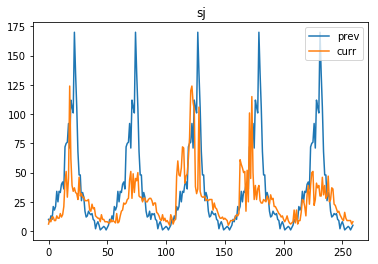

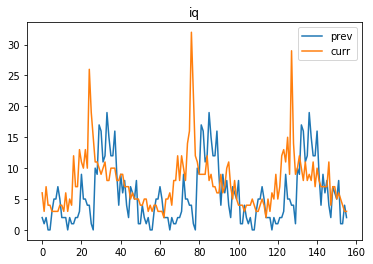

In [52]:
for city in ['sj', 'iq']:
    plt.plot(df_prev.loc[city, 'total_cases_prev'].values, label='prev')
    plt.plot(df_prev.loc[city, 'total_cases_curr'].values, label='curr')
    plt.title(city)
    plt.legend()
    plt.show()

## generate submission file

In [53]:
from src.features.build_features import make_submission

In [54]:
make_submission(submit.reset_index())

('../data/interim/submission_20180530_141052.csv',
 '../data/interim/submission_20180530_141052.csv.zip')